Note - Code to load models and processed data to reproduce submission at the end of the file,  
preprocessing the data and training the models takes a while to run

Also I noticed that some of the code gives errors with newer versions of pandas, it runs on pandas version 1.5.2

## Feature Extraction

In [3]:
import pandas as pd
import warnings
from tqdm import tqdm
from dateutil import relativedelta
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, f1_score,roc_auc_score
from xgboost import XGBClassifier
import xgboost as xgb
tqdm.pandas()
warnings.filterwarnings("ignore")
fraud_per = lambda x :    len(x[x["is_fraud"] == 1])/(len(x[x["is_fraud"] == 1]) + len(x[x["is_fraud"] == 0]))

In [3]:
pd.__version__

'1.5.2'

In [18]:
#Function to save data to training/testing sets
def save_to_x(data):
    data.to_csv("current_train.csv")
    submissionSet = pd.read_csv("./data/test.csv")

    # Merge on Id so that the test set can have feature columns as well
    testX= pd.merge(data, submissionSet, left_on='Id', right_on='Id')
    testX = testX.drop(columns=['is_fraud_x'])
    testX = testX.rename(columns={'is_fraud_y': 'is_fraud'})

    # The training set is where the score is not null
    trainX =  data[data['is_fraud'].notnull()]

    # Save the datasets with the new features for easy access later
    testX.to_csv("./data/X_test.csv", index=False)
    trainX.to_csv("./data/X_train.csv", index=False)

In [31]:
#Note this takes a long time to run
def process(data):
    df = data
    date_time = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')
    dob_date_time = pd.to_datetime(df['dob'], format='%d/%m/%Y')

    df["dob"] = dob_date_time.dt.date
    df["weekday"] = date_time.dt.weekday
    df['trans_date'] = date_time.dt.date
    df['trans_time'] = date_time.dt.time
    df["trans_year"] = date_time.dt.year
    df["trans_month"] = date_time.dt.month
    df["trans_hour"]= date_time.dt.hour
    def process_fun(row):
        wd = ["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]
        row["weekday"] = wd[row["weekday"]]
        cc = str(int(row["cc_num"]))
        row["age"] = relativedelta.relativedelta(row["trans_date"],row["dob"]).years
        row["age_dec"]=row["age"] // 10
        row["MII"] = cc[0]
        return row
    df = df.progress_apply(process_fun,axis=1)
    for cat in ["category","weekday"]:
        df[df[cat].unique()] = pd.get_dummies(df[cat])

    tpc = df.groupby(["street","is_fraud","unix_time"])
    tpc2 = tpc.value_counts()
    df["High_Risk_Merchant"] =df.apply((lambda x : 1 if x["merchant"] in t.keys() else 0),axis= 1)
    df["High_Risk_State"] = df.progress_apply((lambda x : 1 if x["state"] in ["CT","AK","HI","ID"] else 0 ),axis = 1)
    df["Low_Risk_State"] = train_processed.progress_apply((lambda x : 1 if x["state"] in ["CO","OH","WY"] else 0),axis=1)

    def pf_fun(row):
        time = row["unix_time"]
        row["prev_fraud_prior_val"] = 20000000
        row["prev_fraud"] = 20000000
        row["next_fraud"] = 20000000
        try:
            df = tpc2[row["street"]][1]
        except KeyError:
            return row
        pf = 20000000
        nf = 20000000
        pf2 = 20000000
        nf2 = 20000000
        for btime in df.keys():

        if btime[0] < time:
            pf = min(time- btime[0],pf)
        if btime[0] > time:
            pf = btime[0]-time
        if btime[0] < time:
            pf2 = min(time- btime[0],pf2)
        if btime[0] > time:
            nf2 = min(btime[0]-time,nf2)
        row["prev_fraud_prior_val"] = pf
        row["prev_fraud"] = pf2
        row["next_fraud"] = nf2

        return row

    df = df.progress_apply(pf_fun,axis=1)
    df["prior_hour"] = df.progress_apply((lambda x : 1 if x["prev_fraud"] < 3600 else 0),axis = 1)
    df["next_hour"] = df.progress_apply((lambda x :1 if x["next_fraud"] < 3600 else 0 ),axis = 1)
    df["prior_3hour"] = df.progress_apply((lambda x : 1 if x["prev_fraud"] < 10800 else 0),axis = 1)  
    df["next_3hour"] = df.progress_apply((lambda x : 1 if x["next_fraud"] < 10800 else 0),axis = 1) 
    df["prior_day"] = df.progress_apply((lambda x :1 if x["prev_fraud"] < 86400  else 0),axis = 1) 


    return df

# Load the dataset

# Process the DataFrame
trainingSet = pd.read_csv("./data/train.csv")
train_processed = process(trainingSet)
save_to_x(train_processed)

100%|██████████| 555719/555719 [26:16<00:00, 352.60it/s]  


## Data Visualization

In [4]:
train_processed = pd.concat([pd.read_csv("./data/X_train.csv"),pd.read_csv("./data/X_test.csv")])

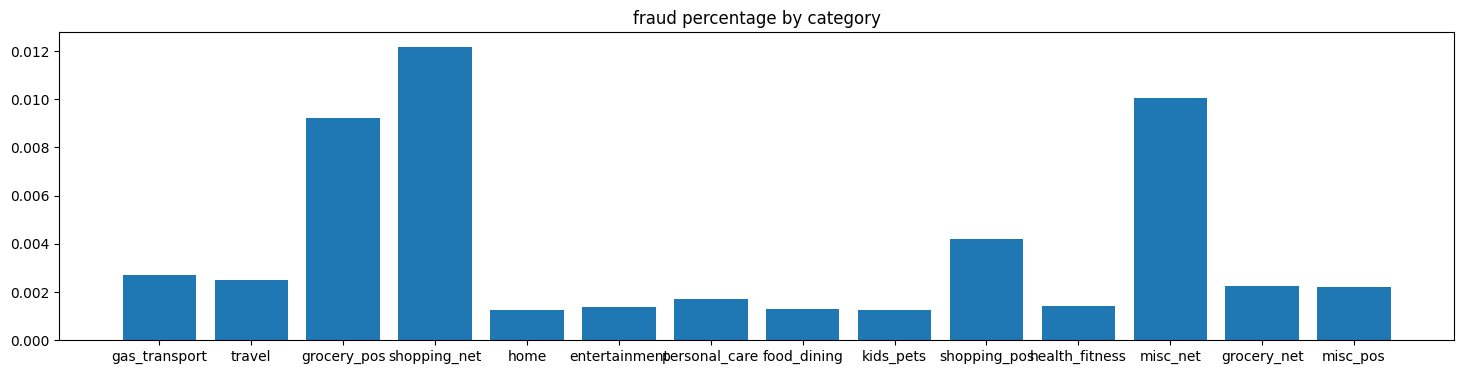

In [359]:
x = []
h = []
fig = plt.figure(figsize=(18,4))
for cat in train_processed["category"].unique():
    x.append(cat)
    h.append(fraud_per(train_processed[train_processed["category"] == cat]))
plt.bar(x,h)
plt.title("fraud percentage by category")
fig.savefig("./figures/categories.png")
plt.show()
    

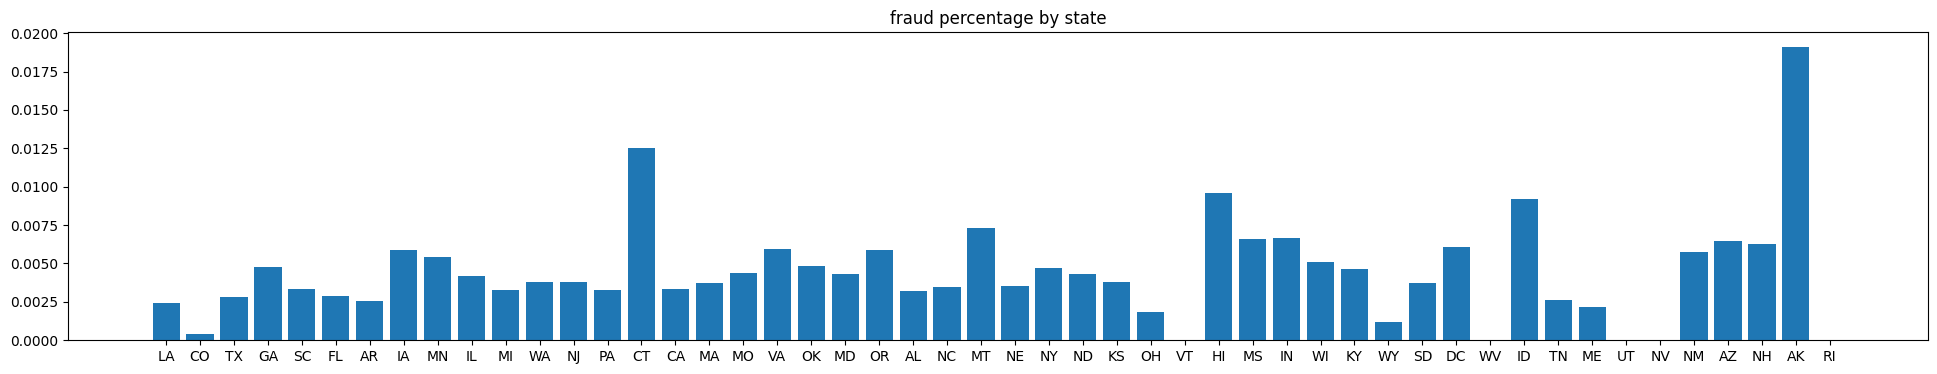

In [6]:
x = []
h = []
fig = plt.figure(figsize=(24,4))
for cat in train_processed["state"].unique():
    x.append(cat)
    h.append(fraud_per(train_processed[train_processed["state"] == cat]))
plt.bar(x,h)
plt.title("fraud percentage by state")
fig.savefig("./figures/states.png")
plt.show()

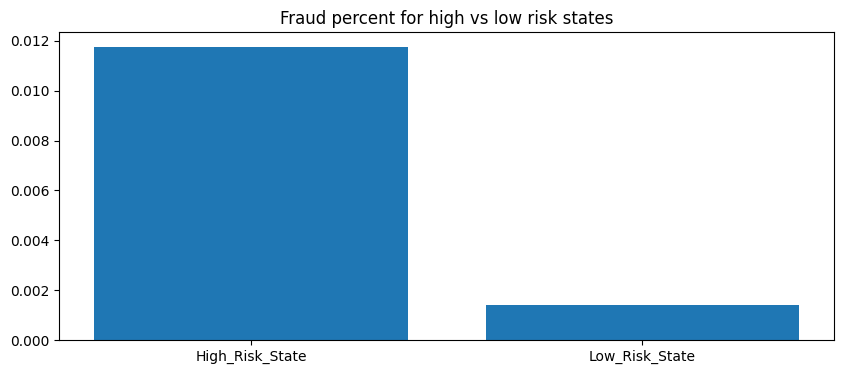

In [335]:
x = ["High_Risk_State","Low_Risk_State"]
h = []
fig = plt.figure(figsize=(10,4))
h.append(fraud_per(train_processed[train_processed["High_Risk_State"] == 1]))
h.append(fraud_per(train_processed[train_processed["Low_Risk_State"] == 1]))
plt.bar(x,h)
plt.title("Fraud percent for high vs low risk states")
fig.savefig("./figures/states.png")
plt.show()

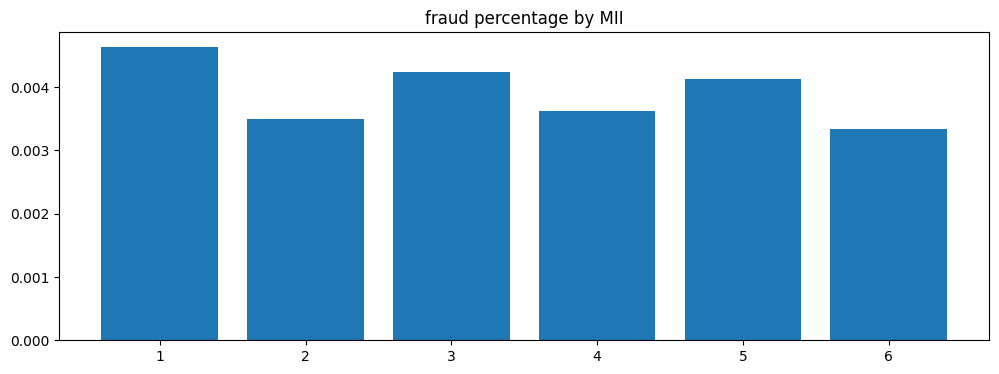

In [356]:
x = []
h = []
fig = plt.figure(figsize=(12,4))
for cat in train_processed["MII"].unique():
    x.append(cat)
    h.append(fraud_per(train_processed[train_processed["MII"] == cat]))
plt.bar(x,h)
plt.title("fraud percentage by MII")
fig.savefig("./figures/MII.png")
plt.show()

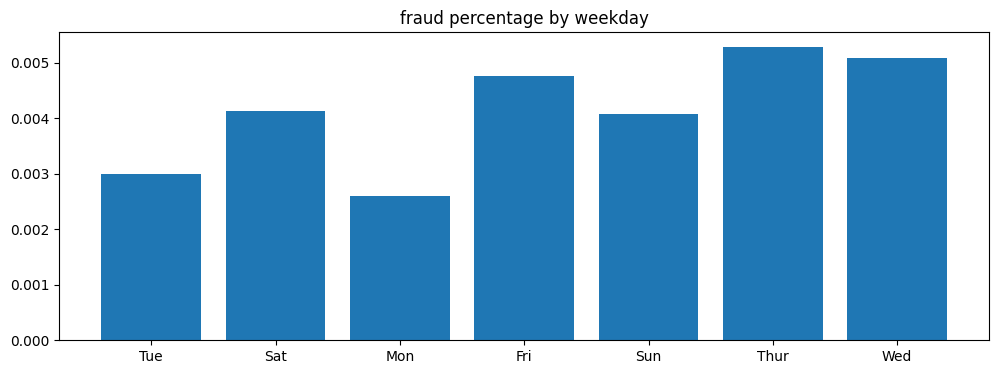

In [355]:
x = []
h = []
fig = plt.figure(figsize=(12,4))
for cat in train_processed["weekday"].unique():
    x.append(cat)
    h.append(fraud_per(train_processed[train_processed["weekday"] == cat]))
plt.bar(x,h)
plt.title("fraud percentage by weekday")
fig.savefig("./figures/weekday.png")
plt.show()

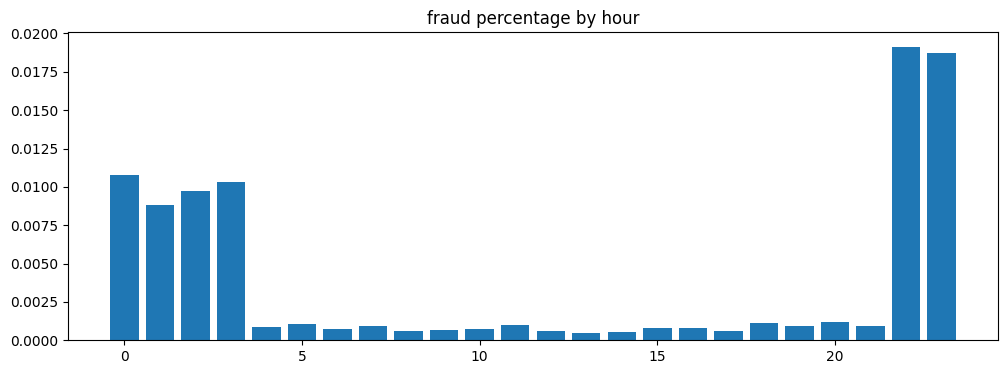

In [5]:
x = []
h = []
fig = plt.figure(figsize=(12,4))
for cat in train_processed["trans_hour"].unique():
    x.append(cat)
    h.append(fraud_per(train_processed[train_processed["trans_hour"] == cat]))
plt.bar(x,h)
plt.title("fraud percentage by hour")
fig.savefig("./figures/hour.png")
plt.show()

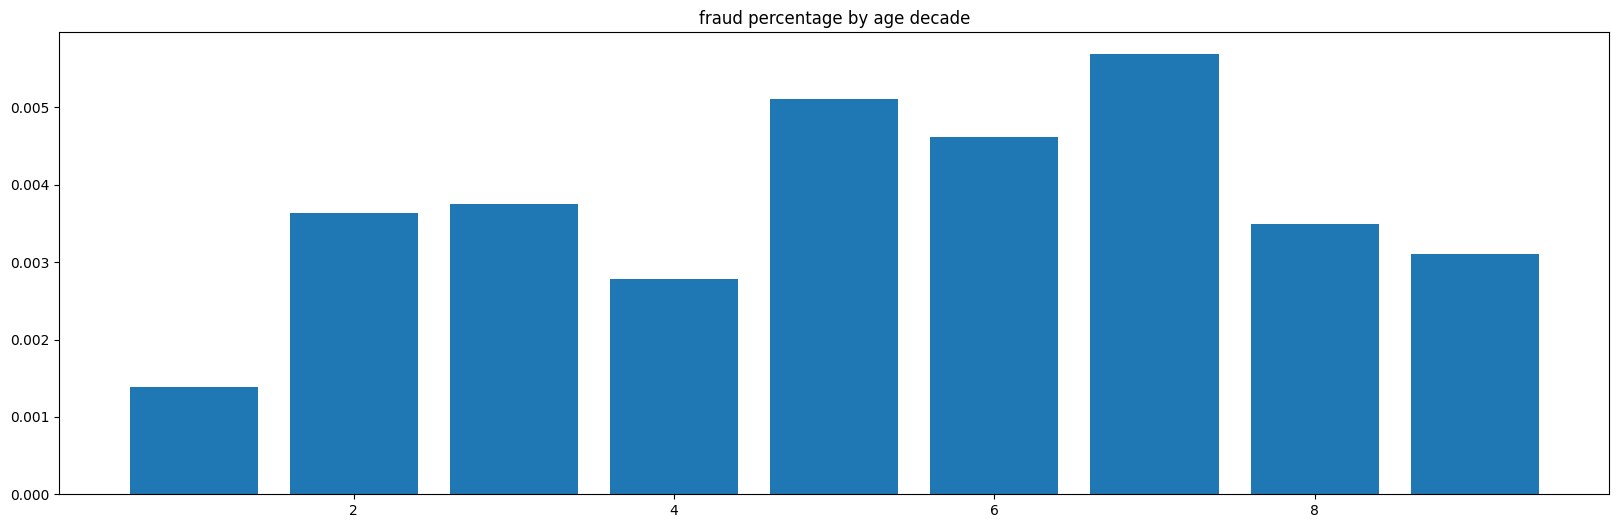

In [337]:
x = []
h = []
fig = plt.figure(figsize=(20,6))
for cat in train_processed["age_dec"].unique():
    x.append(cat)
    h.append(fraud_per(train_processed[train_processed["age_dec"] == cat]))
plt.bar(x,h)
plt.title("fraud percentage by age decade")
fig.savefig("./figures/agedec.png")
plt.show()

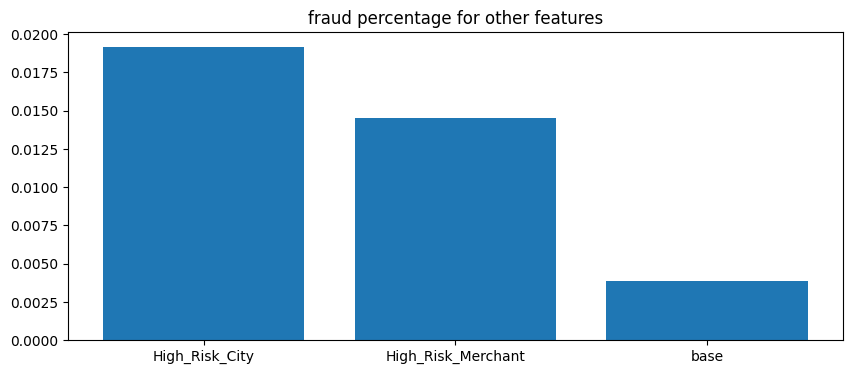

In [353]:
x = ["High_Risk_City","High_Risk_Merchant"]
h = []
fig = plt.figure(figsize=(10,4))
for cat in x:
    h.append(fraud_per(train_processed[train_processed[cat] == 1]))
x.append("base")
h.append(fraud_per(train_processed))
plt.bar(x,h)
plt.title("fraud percentage for other features")
fig.savefig("./figures/misc.png")
plt.show()

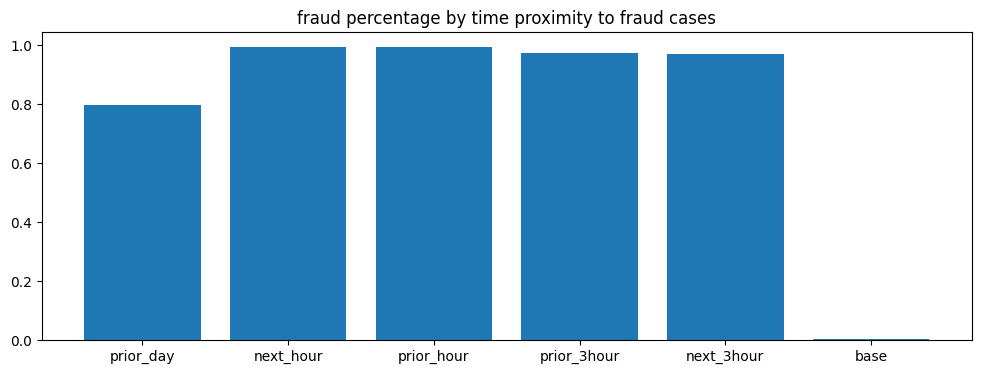

In [354]:
x = ['prior_day',"next_hour",'prior_hour',"prior_3hour","next_3hour"]
h = []
fig = plt.figure(figsize=(12,4))
for cat in x:
    h.append(fraud_per(train_processed[train_processed[cat] == 1]))
x.append("base")
h.append(fraud_per(train_processed))
plt.bar(x,h)
plt.title("fraud percentage by time proximity to fraud cases")
fig.savefig("./figures/timeprox.png")
plt.show()

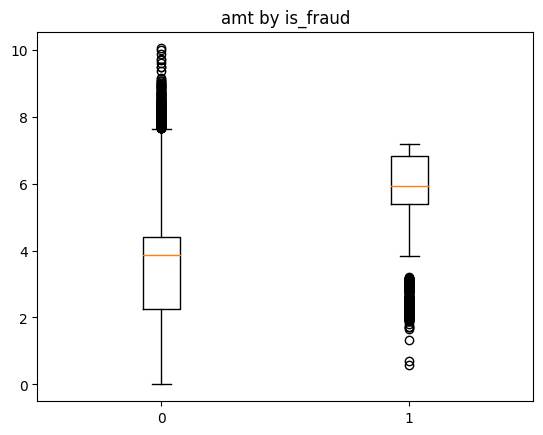

In [351]:
fig,ax = plt.subplots()
ax.boxplot([np.log(train_processed[train_processed["is_fraud"] == 0]["amt"]),np.log(train_processed[train_processed["is_fraud"] == 1]["amt"])],positions = [0,1])
plt.title("amt by is_fraud")
fig.savefig("./figures/amt.png")
plt.show()

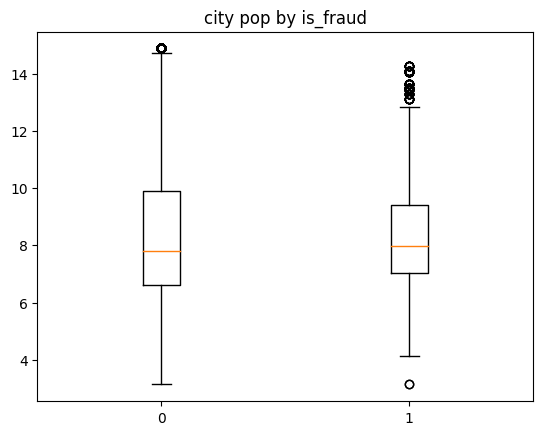

In [350]:
fig,ax = plt.subplots()
ax.boxplot([np.log(train_processed[train_processed["is_fraud"] == 0]["city_pop"]),np.log(train_processed[train_processed["is_fraud"] == 1]["city_pop"])],positions = [0,1])
plt.title("log city pop by is_fraud")
fig.savefig("./figures/amt.png")
plt.show()

## Creating  model

In [313]:
X_train= pd.read_csv("./data/X_train.csv")

X_train = X_train[[ 'age', 'age_dec', 'amt', 'High_Risk_City', 'High_Risk_Merchant','MII',
'city_pop','gas_transport', 'grocery_net', 'grocery_pos', 'health_fitness', 'home','kids_pets','misc_net', 'misc_pos', 'personal_care',
'shopping_net', 'shopping_pos', 'trans_hour', 'travel',"is_fraud","dist","Sun","High_Risk_State","Low_Risk_State",
'prior_day', 'prior_fraud',"next_hour",'prior_hour',"prior_3hour","next_3hour","prev_fraud_prior_val","prev_fraud"]]
# 

# Split training set into training and testing set
w = len(X_train[X_train["is_fraud"] == 1])
w2 = len(X_train[X_train["is_fraud"] == 0])
w = w / (w+w2)


X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['is_fraud'], axis=1),
        X_train['is_fraud'],
        test_size=1/4,
        random_state=1
    )
models =[]
#Ensemble of weighted and unweighted models
for i in range(1,11):
    X_train_processed = X_train._get_numeric_data()
    X_test_processed = X_test._get_numeric_data()
    models.append(XGBClassifier(n_estimators=22, max_depth=12, learning_rate=(0.45 + (i*0.01)), gamma = .45, objective='binary:logistic',\
                                eval_metric= roc_auc_score,grow_policy = "depthwise",scale_pos_weight = ((i * (0.01) + 0.7) * (1/w)), tree_method="auto").fit(X_train_processed, Y_train.values))                            
    models.append(XGBClassifier(n_estimators=22, max_depth=12, learning_rate=(0.45 + (i*0.01)), gamma = .45, objective='binary:logistic',\
                                eval_metric= roc_auc_score,grow_policy = "depthwise", tree_method="auto").fit(X_train_processed, Y_train.values))
    models.append(XGBClassifier(n_estimators=22, max_depth=12, learning_rate=(0.45 + (i*0.01)), gamma = .45, objective='binary:logistic',\
                                eval_metric= roc_auc_score,grow_policy = "depthwise",scale_pos_weight = ((i * (0.01) + 0.7) * (1/w)), tree_method="exact").fit(X_train_processed, Y_train.values))
    models.append(XGBClassifier(n_estimators=22, max_depth=12, learning_rate=(0.45 + (i*0.01)), gamma = .45, objective='binary:logistic',\
                                eval_metric= roc_auc_score,grow_policy = "depthwise", tree_method="exact").fit(X_train_processed, Y_train.values))



F1 score on testing set =  0.9936440677966103


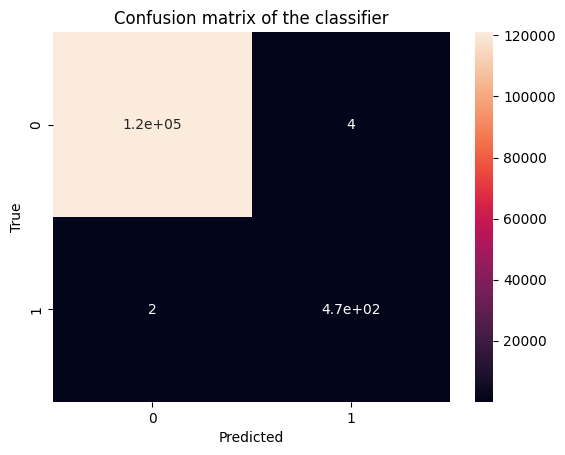

In [314]:

preds_lp= []
for model in models:
    predsp = model.predict_proba(X_test_processed)[:,1]
    preds_lp.append(predsp)

combined_preds  = np.zeros(shape=len(preds_lp[0]))
for i,p in enumerate(preds_lp):
    combined_preds += p
combined_preds/= (len(preds_lp))
combined_preds =np.where(combined_preds > .5,1,0)
    
f1 = f1_score(Y_test, combined_preds)
print("F1 score on testing set = ", f1)
cm = confusion_matrix(Y_test, combined_preds)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Create the Kaggle submission

In [315]:
X_submission = pd.read_csv("./data/X_test.csv")
Ids = X_submission["Id"]

X_submission = X_submission[[ 'age', 'age_dec', 'amt', 'High_Risk_City', 'High_Risk_Merchant','MII',
'city_pop','gas_transport', 'grocery_net', 'grocery_pos', 'health_fitness', 'home','kids_pets','misc_net', 'misc_pos', 'personal_care',
'shopping_net', 'shopping_pos', 'trans_hour', 'travel',"is_fraud","dist","Sun","High_Risk_State","Low_Risk_State",
'prior_day', 'prior_fraud',"next_hour",'prior_hour',"prior_3hour","next_3hour","prev_fraud_prior_val","prev_fraud"]]
X_submission_processed = X_submission._get_numeric_data().drop(columns=['is_fraud'])


print(X_submission_processed.columns)
preds_lp = []
for model in models:
    predsp = model.predict_proba(X_submission_processed)[:,1]
    preds_lp.append(predsp)

combined_preds  = np.zeros(shape=len(preds_lp[0]))
for i,p in enumerate(preds_lp):
    combined_preds += p
combined_preds/= (len(preds_lp))
combined_preds =np.where(combined_preds >= .5,1,0)

X_submission['is_fraud'] = combined_preds
X_submission.is_fraud = X_submission.is_fraud.astype(int)
X_submission["Id"] = Ids
submission = X_submission[['Id', 'is_fraud']]
submission.to_csv("./data/submission.csv", index=False)

Index(['age', 'age_dec', 'amt', 'High_Risk_City', 'High_Risk_Merchant', 'MII',
       'city_pop', 'gas_transport', 'grocery_net', 'grocery_pos',
       'health_fitness', 'home', 'kids_pets', 'misc_net', 'misc_pos',
       'personal_care', 'shopping_net', 'shopping_pos', 'trans_hour', 'travel',
       'dist', 'Sun', 'High_Risk_State', 'Low_Risk_State', 'prior_day',
       'prior_fraud', 'next_hour', 'prior_hour', 'prior_3hour', 'next_3hour',
       'prev_fraud_prior_val', 'prev_fraud'],
      dtype='object')


## Reproduce leaderboard submissions
- Since running the models and preprocessing the data takes a while this code loads the models and data used for the top 2 leaderboard submissions

In [825]:
#Model 
"""
for i in range(1,11):
    X_train_processed = X_train._get_numeric_data()
    X_test_processed = X_test._get_numeric_data()
    models.append(XGBClassifier(n_estimators=22, max_depth=12, learning_rate=(0.45 + (i*0.01)), gamma = .45, objective='binary:logistic',\
                                eval_metric= roc_auc_score,grow_policy = "depthwise",scale_pos_weight = ((i * (0.01) + 0.7) * (1/w)), tree_method="auto").fit(X_train_processed, Y_train.values))                            
    models.append(XGBClassifier(n_estimators=22, max_depth=12, learning_rate=(0.45 + (i*0.01)), gamma = .45, objective='binary:logistic',\
                                eval_metric= roc_auc_score,grow_policy = "depthwise", tree_method="auto").fit(X_train_processed, Y_train.values))
    models.append(XGBClassifier(n_estimators=22, max_depth=12, learning_rate=(0.45 + (i*0.01)), gamma = .45, objective='binary:logistic',\
                                eval_metric= roc_auc_score,grow_policy = "depthwise",scale_pos_weight = ((i * (0.01) + 0.7) * (1/w)), tree_method="exact").fit(X_train_processed, Y_train.values))
    models.append(XGBClassifier(n_estimators=22, max_depth=12, learning_rate=(0.45 + (i*0.01)), gamma = .45, objective='binary:logistic',\
                                eval_metric= roc_auc_score,grow_policy = "depthwise", tree_method="exact").fit(X_train_processed, Y_train.values))
                                
"""
with open("./models/0987_num2_xgb.obj","rb") as file:
    models = pickle.load(file)

X_submission = pd.read_csv("./data/best_model_2_submission_data.csv")
Ids = X_submission["Id"]

X_submission = X_submission[[ 'age', 'age_dec', 'amt', 'High_Risk_City', 'High_Risk_Merchant','MII',
'city_pop','gas_transport', 'grocery_net', 'grocery_pos', 'health_fitness', 'home','kids_pets','misc_net', 'misc_pos', 'personal_care',
'shopping_net', 'shopping_pos', 'trans_hour', 'travel',"is_fraud","dist","Sun","High_Risk_State","Low_Risk_State",
'prior_day', 'prior_fraud',"next_hour",'prior_hour',"prior_3hour","next_3hour","prev_fraud_prior_val","prev_fraud"]]
X_submission_processed = X_submission._get_numeric_data().drop(columns=['is_fraud'])


print(X_submission_processed.columns)
preds_lp = []
for model in models:
    predsp = model.predict_proba(X_submission_processed)[:,1]
    preds_lp.append(predsp)

combined_preds  = np.zeros(shape=len(preds_lp[0]))
for i,p in enumerate(preds_lp):
    combined_preds += p
combined_preds/= (len(preds_lp))
combined_preds =np.where(combined_preds >= .5,1,0)

X_submission['is_fraud'] = combined_preds
X_submission.is_fraud = X_submission.is_fraud.astype(int)
X_submission["Id"] = Ids
submission = X_submission[['Id', 'is_fraud']]
submission.to_csv("./data/submission.2csv", index=False)

NameError: name 'roc_auc_score' is not defined

In [ ]:
#Model

"""
for i in range(1,11):
    models.append(XGBClassifier(n_estimators=22, max_depth=12, learning_rate=(0.5), gamma = .45, objective='binary:logistic',eval_metric= roc_auc_score,grow_policy = "depthwise",scale_pos_weight = ((i * (0.01) + 0.7) * (1/w)), tree_method="auto").fit(X_train_processed, Y_train.values))
for i in range(1,12):
    models.append(XGBClassifier(n_estimators=22, max_depth=12, learning_rate=(0.495 + (i*0.01)), gamma = .45, objective='binary:logistic',eval_metric= roc_auc_score,grow_policy = "depthwise", tree_method="auto").fit(X_train_processed, Y_train.values))
for i in range(1,11):
    models.append(XGBClassifier(n_estimators=22, max_depth=12, learning_rate=(0.5), gamma = .45, objective='binary:logistic',eval_metric= roc_auc_score,grow_policy = "depthwise",scale_pos_weight = ((i * (0.01) + 0.7) * (1/w)), tree_method="exact").fit(X_train_processed, Y_train.values))
for i in range(1,12):
    models.append(XGBClassifier(n_estimators=22, max_depth=12, learning_rate=(0.495 + (i*0.01)), gamma = .45, objective='binary:logistic',eval_metric= roc_auc_score,grow_policy = "depthwise", tree_method="exact").fit(X_train_processed, Y_train.values))

"""

with open("./models/0987_xgb.obj","rb") as file:
    models = pickle.load(file)

X_submission = pd.read_csv("./data/best_model_submission_data.csv")
Ids = X_submission["Id"]
X_submission["prev_fraud"] = X_submission["prev_fraud_prior_val"]
X_submission["closest_fraud"] = X_submission["closest_fraud_prior_val"]
X_submission["next_fraud"] = X_submission["next_fraud_prior_val"]

X_submission = X_submission[[ 'age', 'age_dec', 'amt', 'High_Risk_City', 'High_Risk_Merchant','MII',
'city_pop','gas_transport', 'grocery_net', 'grocery_pos', 'health_fitness', 'home',
'kids_pets','misc_net', 'misc_pos', 'personal_care',
'shopping_net', 'shopping_pos', 'trans_hour', 'travel',"is_fraud","dist","Sun","High_Risk_State","Low_Risk_State",
'prior_day', 'prior_fraud',"next_hour",'prior_hour',"prior_3hour","next_3hour","prev_fraud","next_fraud","closest_fraud"]]
X_submission_processed = X_submission._get_numeric_data().drop(columns=['is_fraud'])


print(X_submission_processed.columns)
preds_lp = []
for model in models:
    predsp = model.predict_proba(X_submission_processed)[:,1]
    preds_lp.append(predsp)

combined_preds  = np.zeros(shape=len(preds_lp[0]))
for i,p in enumerate(preds_lp):
    combined_preds += p
combined_preds/= (len(preds_lp))
combined_preds =np.where(combined_preds >= .5,1,0)

X_submission['is_fraud'] = combined_preds
X_submission.is_fraud = X_submission.is_fraud.astype(int)
X_submission["Id"] = Ids
submission = X_submission[['Id', 'is_fraud']]
submission.to_csv("./data/submission.csv", index=False)


